In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os

In [2]:
run_range = range(0,50)
blocks_range = range(1,11)
simulation_range = [0,1,2,3,4,5]#range(8,10)

# run_range = range(0,5)
# blocks_range = range(1,2)
# simulation_range = [0,1,8,9]#range(0,1)

sim_names = ["long session - set 1", "long session - set 2",
             "long session depth 2 - fit depth 3", "long session depth 3 - fit depth 2",
             "multi-session - set 1", "multi-session - set 2"];

num_samples = 20000;

alphas = np.zeros((num_samples, len(run_range), len(blocks_range), len(simulation_range), 3))
taus   = np.zeros((num_samples, len(run_range), len(blocks_range), len(simulation_range)))

alphas_true = np.zeros((len(simulation_range), 3))
taus_true = np.zeros((len(simulation_range)))


results_directory = "Results/Simulations"

depth = 3
alpha_strs = ["no", "one_back", "two_back", "three_back"]
alpha_names = ["alpha_concentration_" + alpha_strs[dd] + "_context" for dd in range(depth)]

delete_bad_files = False

for sim_idx, sim_num in enumerate(simulation_range):
    for run_idx, run_num in enumerate(run_range):
        for block_idx, block_num in enumerate(blocks_range):
            filename = "{results_directory}/Sim_{sim_num}_block_{block_num}_run_{run_num}.pkl".format(results_directory=results_directory, sim_num=sim_num, block_num=block_num, run_num=run_num)
            if(not os.path.isfile(filename)):
                raise RuntimeError("Results file not found: " + filename)
                # throw error
            
            # load file
            with open(filename, "rb") as results_file:
                results = pickle.load(results_file)


                nwarmup = results["samples"]["num_warmup_samples"]
                for ii in range(3):
                    alphas[:,run_idx,block_idx,sim_idx,ii] = results["samples"]["alphas"][nwarmup:,ii]
                taus[:,run_idx,block_idx,sim_idx] = np.exp(results["samples"]["log_taus"][nwarmup:,0])

                for ii, pname in enumerate(alpha_names):
                    alphas_true[sim_idx,ii] = results["true_parameters"][pname]
                taus_true[sim_idx] = results["true_parameters"]["within_session_A_time_constant"]

                #connection_data = results["simulation_info"]["connection_data"]
                #print("cts = " + str(np.sum(connection_data["C_y"][:,-1] == 0)) + ", "  + str(np.sum(connection_data["C_y"][:,-1] == 1)) + ", "  + str(np.sum(connection_data["C_y"][:,-1] == 2)))
                
                s_index = range(results["samples"]["num_warmup_samples"], results["samples"]["num_warmup_samples"] + num_samples)
                rr = np.mean(results["samples"]["accepted"][s_index])
                print("Run " + str(run_idx) + ", block_idx " + str(block_idx) + ": rate = " + str(rr) + ", step size = " + str(np.sqrt(results["MCMC_info"]["step_size_settings"]["step_size_fixed"])))
                if(rr < 0.15):
                    if(delete_bad_files):
                        print("Failure!")
                        os.remove(filename)
                    else:
                        raise RuntimeError("Failure!")

Run 0, block_idx 0: rate = 0.2291, step size = 0.8462631983795336
Run 0, block_idx 1: rate = 0.21895, step size = 0.8489470940984892
Run 0, block_idx 2: rate = 0.23965, step size = 0.7286917896013444
Run 0, block_idx 3: rate = 0.22245, step size = 0.717140013279729
Run 0, block_idx 4: rate = 0.2405, step size = 0.6630633948707976
Run 0, block_idx 5: rate = 0.2231, step size = 0.6655140454727223
Run 0, block_idx 6: rate = 0.24105, step size = 0.6249635518340223
Run 0, block_idx 7: rate = 0.2218, step size = 0.6296485374029333
Run 0, block_idx 8: rate = 0.21765, step size = 0.5858897938047186
Run 0, block_idx 9: rate = 0.21615, step size = 0.5521958273117998
Run 1, block_idx 0: rate = 0.22615, step size = 0.8779213738878899
Run 1, block_idx 1: rate = 0.24125, step size = 0.7964142310914482
Run 1, block_idx 2: rate = 0.22205, step size = 0.7363813036251549
Run 1, block_idx 3: rate = 0.25415, step size = 0.5929146855723793
Run 1, block_idx 4: rate = 0.235, step size = 0.6178903341537273
Ru

In [3]:
median_alphas = np.median(alphas,axis=0)
median_taus = np.median(taus,axis=0)
alphas_true[np.isinf(alphas_true)] = 0


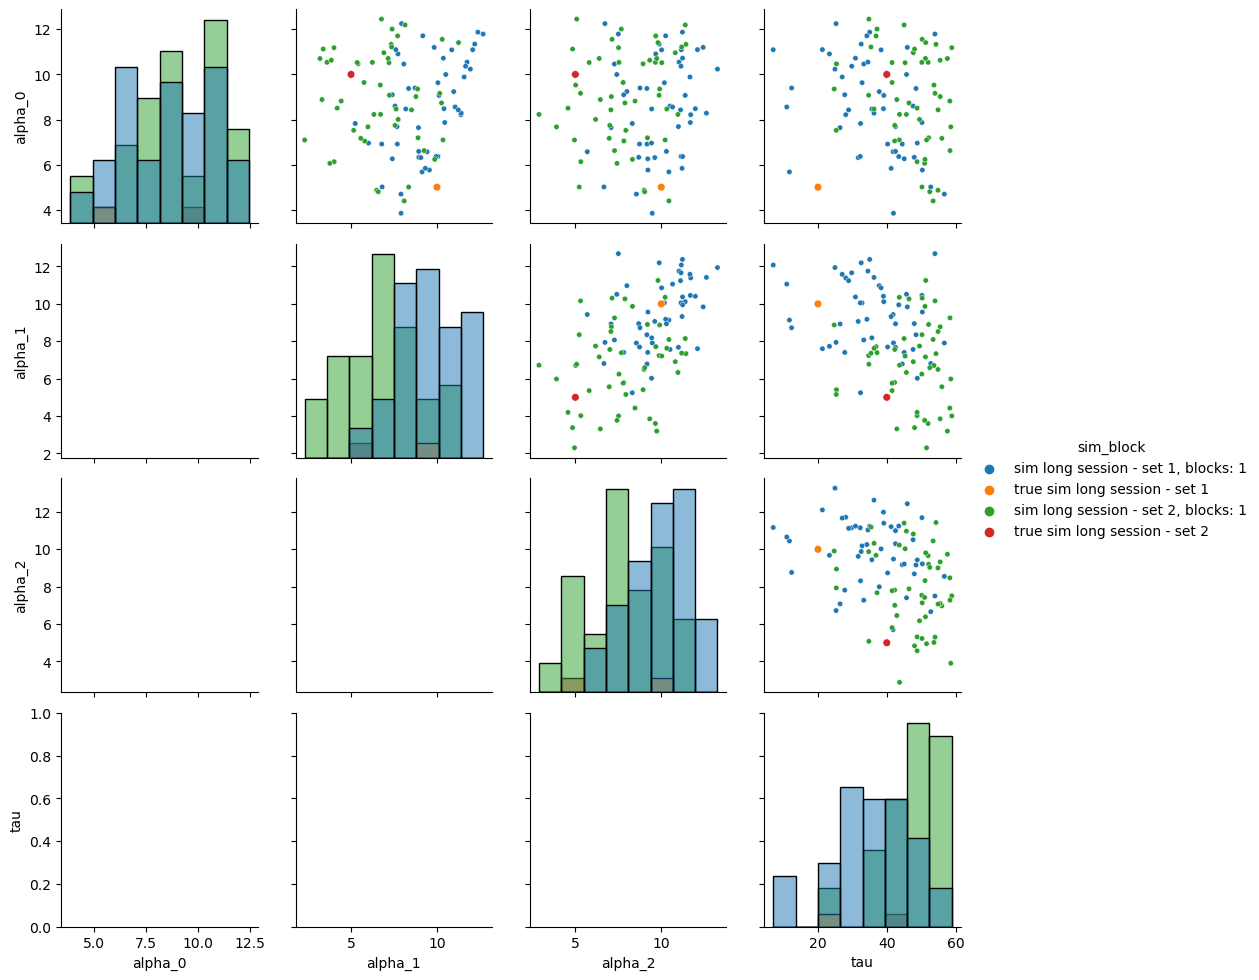

In [14]:


def make_comparison_plot(m_taus, m_alphas, sim_nums, block_nums):
    true_size = 30;
    sim_size = 15;

    df = pd.DataFrame(columns=["alpha_0", "alpha_1", "alpha_2", "tau", "sim", "blocks", "size", "true"])
    for sim_num, block_num in zip(sim_nums, block_nums):
        sim_idx   = simulation_range.index(sim_num) 
        block_idx = blocks_range.index(block_num)

        vars_1 = [m_alphas[:,block_idx,sim_idx,:].squeeze(), m_taus[:,block_idx,sim_idx][:,np.newaxis], 
                    sim_num*np.ones((m_taus.shape[0],1), dtype=int),
                    block_num*np.ones((m_taus.shape[0],1), dtype=int),
                    sim_size*np.ones((m_taus.shape[0],1), dtype=int), np.zeros((m_taus.shape[0],1), dtype=bool)]

        df_c = pd.DataFrame(np.concatenate(vars_1,axis=1), columns=["alpha_0", "alpha_1", "alpha_2", "tau", "sim", "blocks", "size", "true"])
        df = pd.concat([df,df_c])

        df_c = pd.DataFrame(np.array([alphas_true[sim_idx,0], alphas_true[sim_idx,1], alphas_true[sim_idx,2], taus_true[sim_idx],
                        sim_num, block_num, true_size, True])[np.newaxis,:],
                        columns=["alpha_0", "alpha_1", "alpha_2", "tau", "sim", "blocks", "size", "true"])
        df = pd.concat([df,df_c])
    df = df.astype({'sim':'category', "blocks" : "int", 'true' : 'bool'})
    # df['sim'] = df['sim'].cat.rename_categories(dict(zip(range(0,len(sim_names)), sim_names)))
    df['sim'] = df['sim'].cat.rename_categories(dict(enumerate(sim_names)))

    df["sim_block"] = "sim " + df["sim"].astype("string") + ", blocks: " + df["blocks"].astype("string")
    df["sim_block"][df["true"]] = "true sim " + df["sim"][df["true"]].astype("string")
    g = sns.PairGrid(df, diag_sharey=False, hue="sim_block", vars=["alpha_0", "alpha_1", "alpha_2", "tau"])
    # g = sns.PairGrid(df, diag_sharey=False, hue="sim_block", vars=[ "tau", "alpha_1"])
    g.map_upper(sns.scatterplot, s=df["size"])
    g.map_diag(sns.histplot)
    g.add_legend()
make_comparison_plot(median_taus, median_alphas, sim_nums=[0,1], block_nums=[1,1])



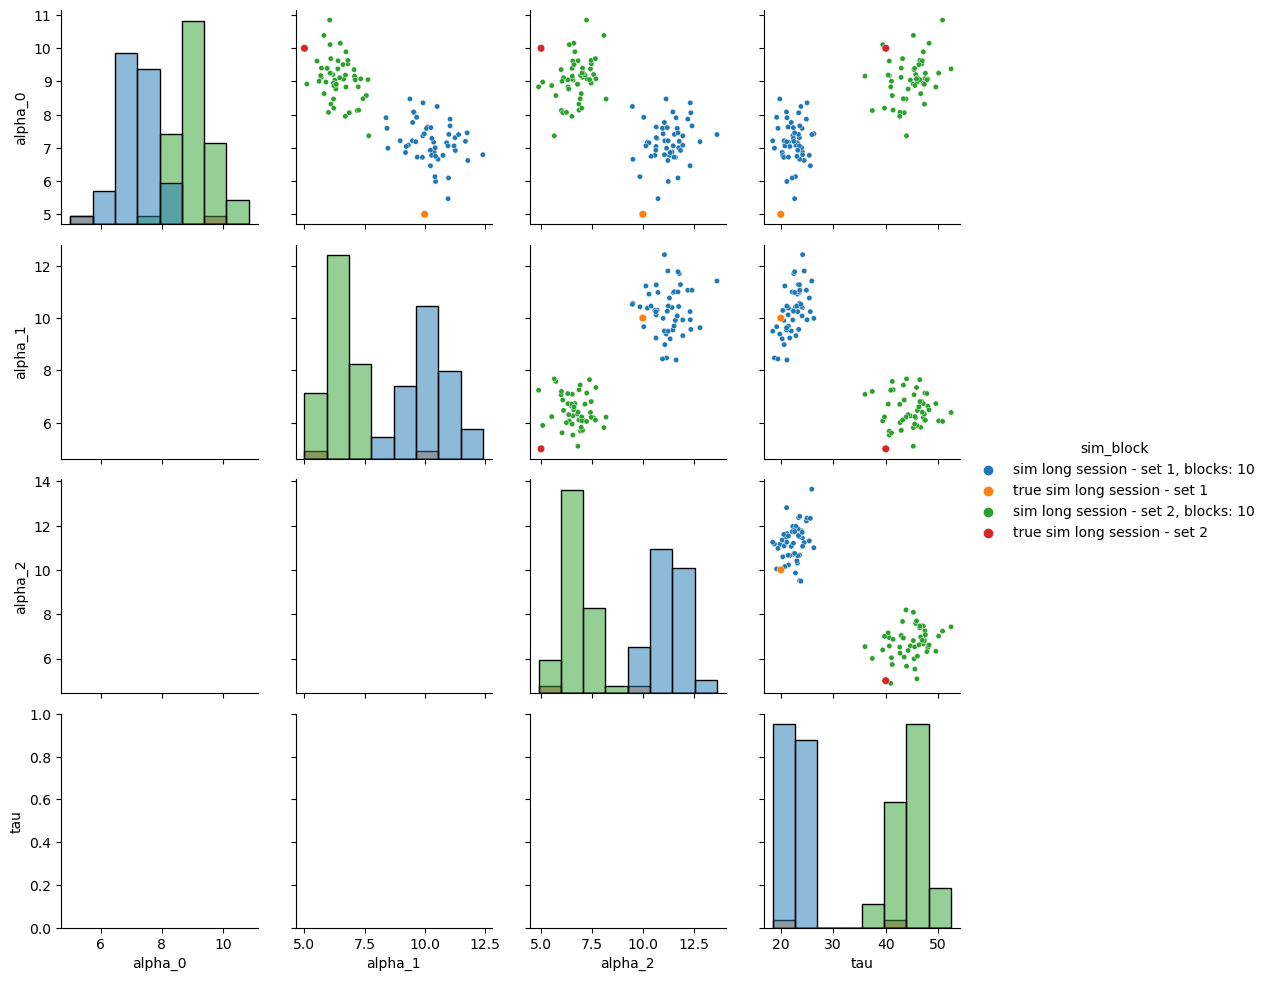

In [39]:
N_samples = 50;
sample_size = 10;
rng = np.random.Generator(np.random.MT19937(100))

sampled_avg_alphas = np.zeros((N_samples,) + median_alphas.shape[1:])
sampled_avg_taus = np.zeros((N_samples,) + median_taus.shape[1:])

for ii in range(N_samples):
    ss = rng.permutation(median_alphas.shape[0])[:sample_size]
    sampled_avg_alphas[ii,...] = np.mean(median_alphas[ss,...],axis=0)
    sampled_avg_taus[ii,...] = np.mean(median_taus[ss,...],axis=0)


make_comparison_plot(sampled_avg_taus, sampled_avg_alphas, sim_nums=[0,1], block_nums=[1] * 2)

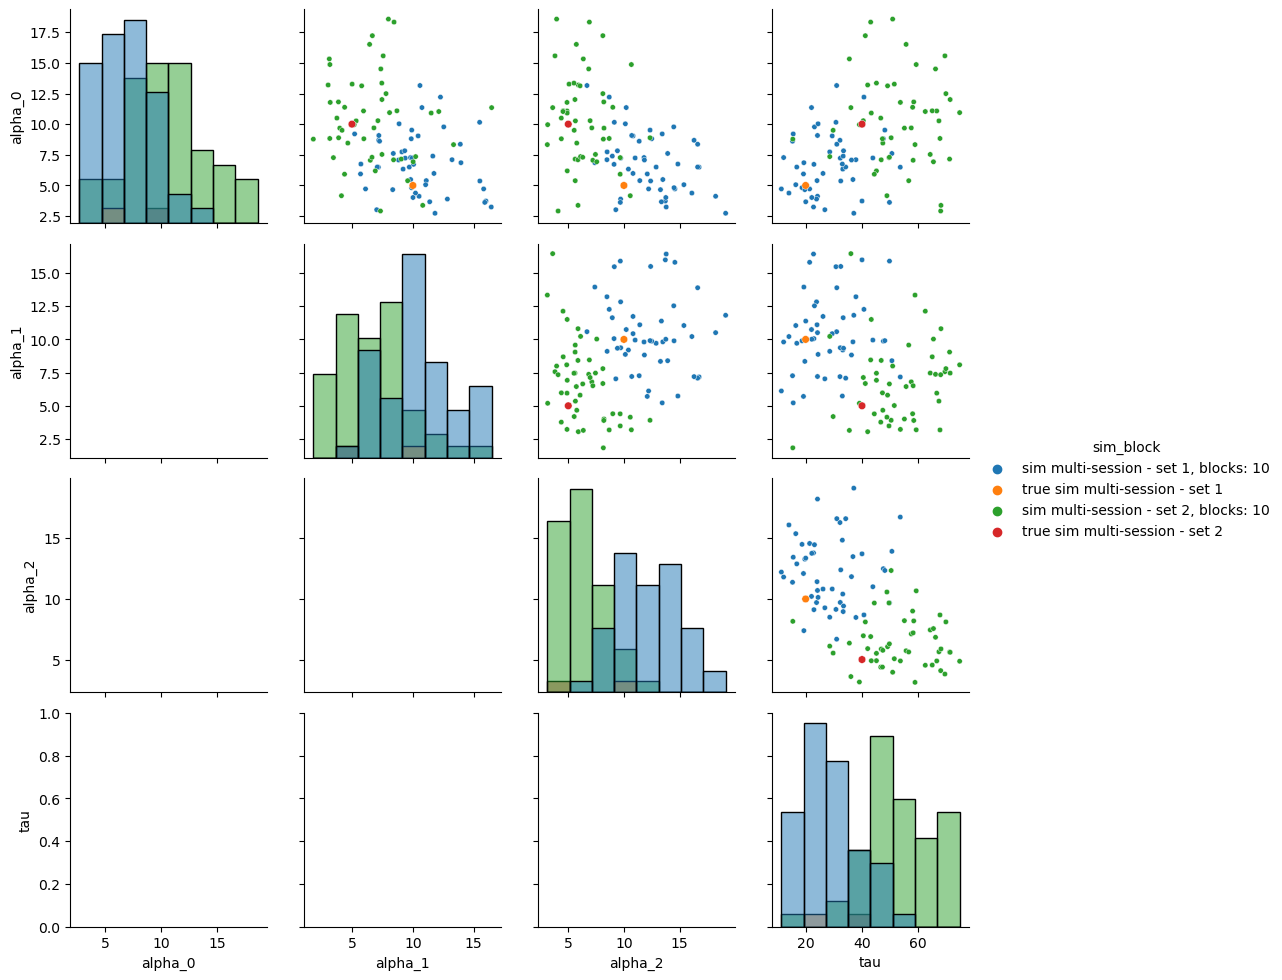

In [29]:

make_comparison_plot(median_taus, median_alphas, sim_nums=[4,5], block_nums=[10] * 2)

In [33]:
N_samples = 50;
sample_size = 10;
rng = np.random.Generator(np.random.MT19937(100))

sampled_avg_alphas2 = np.zeros((N_samples,) + median_alphas.shape[1:])
sampled_avg_taus2 = np.zeros((N_samples,) + median_taus.shape[1:])

for ii in range(N_samples):
    ss = rng.permutation(alphas.shape[1])[:sample_size]
    sampled_avg_alphas2[ii,...] = np.median(alphas[:,ss,...],axis=(0,1))
    sampled_avg_taus2[ii,...] = np.median(taus[:,ss,...],axis=(0,1))



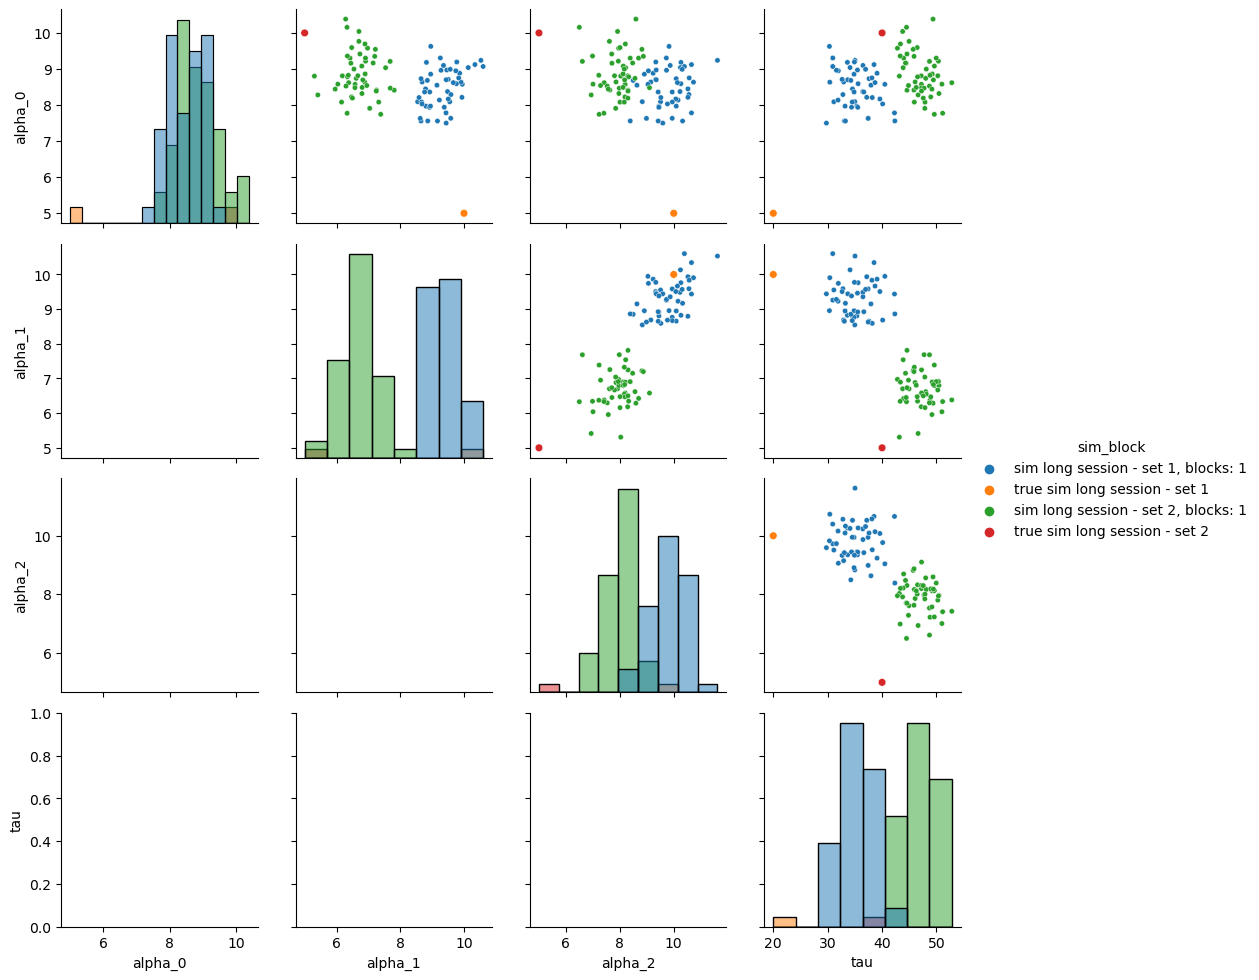

In [38]:

make_comparison_plot(sampled_avg_taus2, sampled_avg_alphas2, sim_nums=[0,1], block_nums=[1] * 2)